In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

In [3]:
# Load an image
img = cv2.imread('./data/grid_output/grid_0_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

In [4]:
# Gaussian Filter
gaussian_filtered =  cv2.GaussianBlur(img, (5,5), 0)

In [5]:
# Apply Median Filter
median_filtered = cv2.medianBlur(img, 5)  # 5 is the kernel size

In [6]:
# Apply Bilateral Filter
bilateral_filtered = cv2.bilateralFilter(img, 5, 150, 150)
bilateral_filtered2 = cv2.bilateralFilter(img, 5, 75, 75)

In [7]:
import numpy as np
from scipy.ndimage import uniform_filter

# TODO: Look into luminance-based approach for combining the RGB channels, this may improve edge-preservation of the algorithm

# Applies to grayscale only
def kuwahara_filter_single_channel(img, window_size):
    print("Running kh filter single channel")
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")

    radius = window_size // 2 + 1
    subregion_diff = radius // 2
    padding = radius - 1
    rows, cols = img.shape[:2]
    pad_width = ((padding, padding), (padding, padding))
    padded = np.pad(img, pad_width, mode='reflect')
    
    result = np.zeros_like(padded)

    means = uniform_filter(padded, size=radius+1, mode='constant', cval=0.0)
    sqr_means = uniform_filter(padded**2, size=radius+1, mode='constant', cval=0.0)
    variances = sqr_means - means**2

    offsets = np.array([(subregion_diff, subregion_diff), 
                        (-subregion_diff, subregion_diff), 
                        (subregion_diff, -subregion_diff), 
                        (-subregion_diff, -subregion_diff)])

    for r in range(padding, rows):
        for c in range(padding, cols):
            subregion_variances = variances[r + offsets[:, 0], c + offsets[:, 1]]
            min_index = np.argmin(subregion_variances)
            min_offset = offsets[min_index]
            result[r, c] = means[r + min_offset[0], c + min_offset[1]]  
    
    return result[padding:-padding, padding:-padding].astype(np.uint8)

In [10]:
def kuwahara_filter_rgb(img, window_size):
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Input must be an RGB image")
    
    result = np.zeros_like(img)
    for i in range(3):  # Process each channel
        result[:,:,i] = kuwahara_filter_single_channel(img[:,:,i], window_size)
    
    return result.astype(np.uint8)

In [9]:
import multiprocessing as mp

def kuwahara_filter_rgb(img, window_size):
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Input must be an RGB image")
    print("Kuwahara filter rgb")
    with mp.Pool() as pool:
        results = pool.map(kuwahara_filter_single_channel, 
                           [(img[:,:,i], window_size) for i in range(3)])
    
    return np.stack(results, axis=-1).astype(np.uint8)

Running kh filter single channel
Running kh filter single channel
Running kh filter single channel
Running kh filter single channel
Running kh filter single channel
Running kh filter single channel
Running kh filter single channel
Running kh filter single channel
Running kh filter single channel


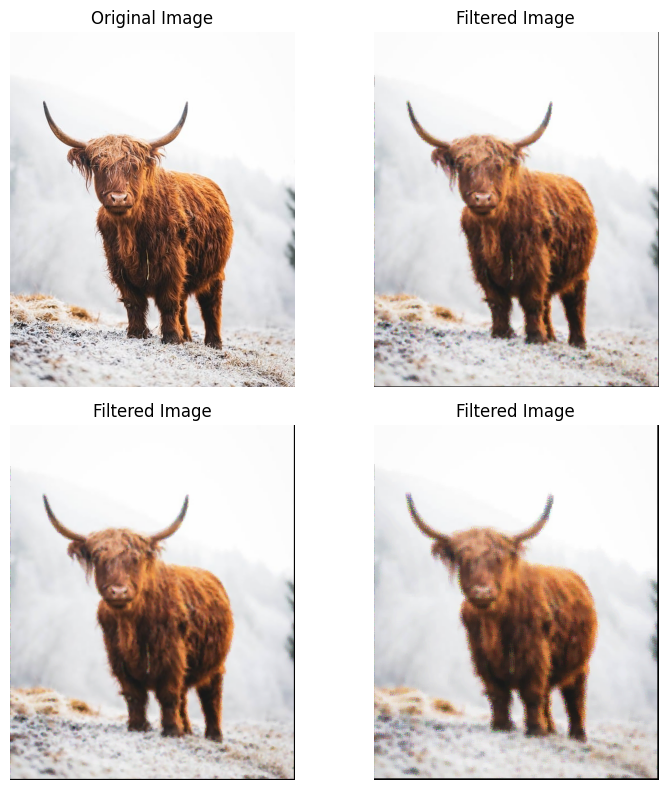

(640, 512, 3)


In [19]:
cattle_bgr = cv2.imread('./highland-cattle-8183107_640.jpg')
cattle = cv2.cvtColor(cattle_bgr, cv2.COLOR_BGR2RGB)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

cattle_kh1 = kuwahara_filter_rgb(cattle, 3)
cattle_kh2 = kuwahara_filter_rgb(cattle, 5)
cattle_kh3 = kuwahara_filter_rgb(cattle, 7)

ax1.imshow(cattle)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(cattle_kh1)
ax2.set_title('Filtered Image')
ax2.axis('off')

ax3.imshow(cattle_kh2)
ax3.set_title('Filtered Image')
ax3.axis('off')

ax4.imshow(cattle_kh3)
ax4.set_title('Filtered Image')
ax4.axis('off')


# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

print(cattle.shape)

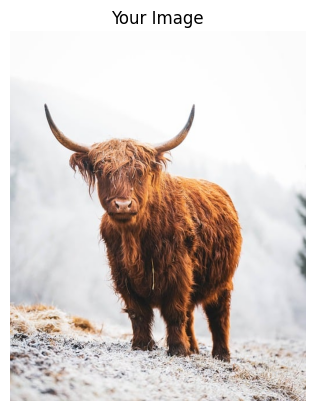

In [18]:
cattle_bgr = cv2.imread('./highland-cattle-8183107_640.jpg')
cattle = cv2.cvtColor(cattle_bgr, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(cattle)
plt.axis('off')  # Hide axis
plt.title('Your Image')
plt.show()

In [119]:
from pprint import pprint

radius = 1
window_size = 3

matrix = np.array([
    [[1, 2], [3, 4], [5, 6]],
    [[9, 10], [11, 12], [13, 14]],
    [[17, 18], [19, 20], [21, 22]]
])
matrix = matrix.reshape(3, 6)

pad_width = ((radius, radius), (radius, radius))
padded = np.pad(matrix, pad_width, mode='reflect')

result = np.zeros_like(matrix)

means = uniform_filter(padded, size=window_size, mode='constant', cval=0.0)
sqr_means = uniform_filter(padded**2, size=window_size, mode='constant', cval=0.0)
variances = sqr_means - means**2

r = 1
c = 1

subregion_diff = 1
offsets = np.array([(subregion_diff, subregion_diff),
                    (subregion_diff, -subregion_diff),
                    (-subregion_diff, subregion_diff),
                    (-subregion_diff, -subregion_diff)])
subregion_variances = variances[r + offsets[:, 0], c + offsets[:, 1]]
values = [variances[1 + dy, 1 + dx] for dy, dx in offsets]

# print(f"means: {means[r-1:r+2, c-1:c+2]}")  # 3x3 neighborhood
# print(f"variances: {variances[r-1:r+2, c-1:c+2]}")  # 3x3 neighborhood
print(f"subregion_variances: {subregion_variances}")
# print(f"min_index: {min_index}")
# print(f"min_offset: {min_offset}")
# print(f"kh_pixel: {kh_pixel}")
# print(f"result[{r}, {c}]: {result[r, c]}")


#print(f"{padded}\n\n{means}\n\n{variances}\n")


#uniform_filter(padded, size=window_size, mode='constant', cval=0.0)
# print(padded[radius:-radius, radius:-radius])
# print(means)

subregion_variances: [42 52 25 16]
